<a href="https://colab.research.google.com/github/zahrael97/COVID-19-detection-using-deep-Learning/blob/master/VGG/VGG16Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid Detection using Transfer Learning**

In [1]:
# importing all the required libraries and modules

import numpy as np
import os, random
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Path of various directories
# Dataset : Chest X-Ray Images (Pneumonia) from Kaggle 

TRAIN_DIR = '/content/drive/My Drive/Dataset_Zahra/train'
TEST_DIR = '/content/drive/My Drive/Dataset_Zahra/test'
#VAL_DIR = '/content/drive/My Drive/chest_xray/val'

Covid_train = '/content/drive/My Drive/chest_xray/train/Covid'
normal_train = '/content/drive/My Drive/chest_xray/train/normal'

Covid_test = '/content/drive/My Drive/chest_xray/test/Covid'
normal_test = '/content/drive/My Drive/chest_xray/test/normal'

#pneumonia_val = '/content/drive/My Drive/chest_xray/val/PNEUMONIA'
#normal_val = '/content/drive/My Drive/chest_xray/val/NORMAL'

# **Customizing the InceptionResNetV3 model**

In [4]:
base_model=VGG16(weights='imagenet',include_top=False)
# and slices off the top layer which is the one that classifies objects into various classes (we don't want this layer)

# Setting up the pre-trained weights of the inceptionv3 model as non-trainable
for layer in base_model.layers:
    layer.trainable=False       

# Adding new layers on top of the base model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation - here, we have only 2 classes (Pneumonia & Normal)

58892288/58889256 [==============================] - 2s 0us/step


In [5]:
# Specify the inputs
# Specify the outputs
model=Model(inputs=base_model.inputs,outputs=preds)

# A new model has been created based on our architecture
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [6]:
# Name of all the layers in our new model which is built on top of the Inceptionv3 model (look at No. 311 till final layer)
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1
21 dense_2
22 dense_3
23 dense_4


## **Data Preparation**

In [10]:
def dir_file_count(directory):
  #Total number of files present inside the 'directory'
  return sum([len(files) for r, d, files in os.walk(directory)])

# Configuration parameters 
rescale = 1./255
target_size = (224, 224)
batch_size = 32            #Specifying the batch size
class_mode = 'categorical'

# Augment the training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
#val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
#val_generator = val_datagen.flow_from_directory(VAL_DIR, 
  #                                              target_size=target_size,
  #                                              class_mode=class_mode,
  #                                              batch_size=dir_file_count(VAL_DIR),
    #                                            shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(TEST_DIR),
                                                  shuffle=False)

Found 376 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


# **Training Process of our custom model**

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Loss function will be categorical cross entropy
# Evaluation metric will be accuracy

# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=30,                                # Specifying the no. of epochs
                              validation_data=test_generator,
                              validation_steps=len(test_generator))

Epoch 1/30
12/12 [==============================] - 19s 2s/step - loss: 0.0293 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9836
Epoch 2/30
12/12 [==============================] - 17s 1s/step - loss: 0.0118 - accuracy: 0.9947 - val_loss: 0.0563 - val_accuracy: 0.9918
Epoch 3/30
12/12 [==============================] - 18s 1s/step - loss: 0.0024 - accuracy: 0.9973 - val_loss: 0.0322 - val_accuracy: 0.9918
Epoch 4/30
12/12 [==============================] - 18s 1s/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 0.1039 - val_accuracy: 0.9672
Epoch 5/30
12/12 [==============================] - 18s 1s/step - loss: 6.0478e-04 - accuracy: 1.0000 - val_loss: 0.0725 - val_accuracy: 0.9918
Epoch 6/30
12/12 [==============================] - 18s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/30
12/12 [==============================] - 18s 1s/step - loss: 1.7136e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/30
1

# **Evaluation metrics (Performance)**

In [12]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 
confusion = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
print("-"*70)
print("Report")
print("-"*70)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*70)
print("\n\n")

cls_report_print = classification_report(y_true, y_pred, target_names=['covid', 'Normal'])

cls_report = classification_report(y_true, y_pred, target_names=['covid', 'Normal'], output_dict=True)

print("-"*70)
print("covid Prediction")
print("-"*70)
print(cls_report_print)
print("-"*70)

print( confusion)

1/1 [==============================] - 5s 5s/step
----------------------------------------------------------------------
Report
----------------------------------------------------------------------
Precision     : 96.83%
Recall        : 98.39%
F1-Score      : 97.60%
----------------------------------------------------------------------



----------------------------------------------------------------------
covid Prediction
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.98      0.97      0.97        60
      Normal       0.97      0.98      0.98        62

    accuracy                           0.98       122
   macro avg       0.98      0.98      0.98       122
weighted avg       0.98      0.98      0.98       122

----------------------------------------------------------------------
[[58  2]
 [ 1 61]]


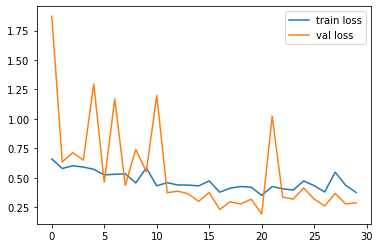

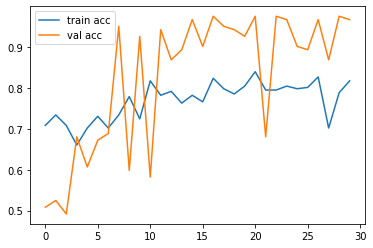

<Figure size 432x288 with 0 Axes>

In [0]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

import tensorflow as tf

from keras.models import load_model

model.save('InceptionV3.h5')